num_of_epochs= 30 batch_size= 16 eta_min= 0.001 iterations_per_epoch= 43.0 t0= 645.0 alpha= 0.5 gamma= 0.1 T= 1290.0


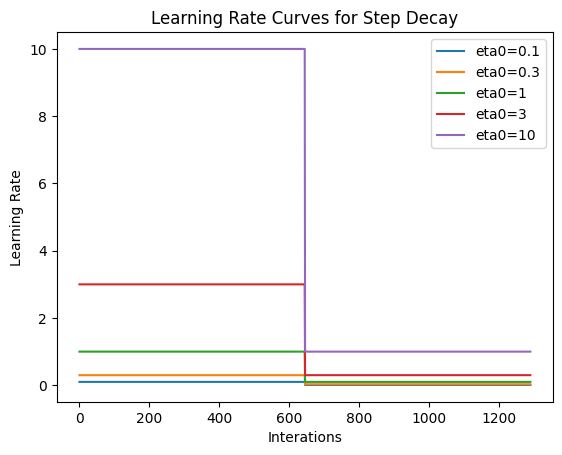

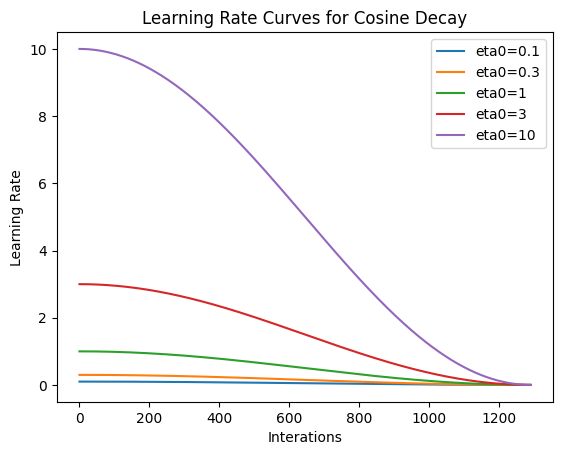

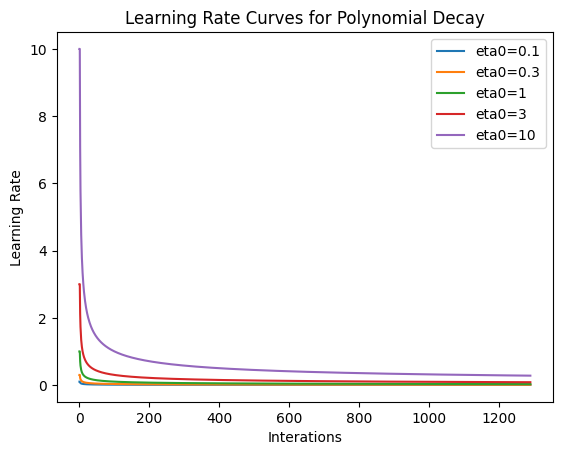

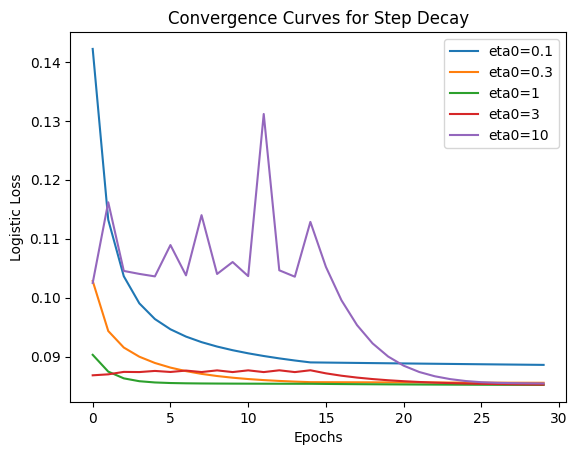

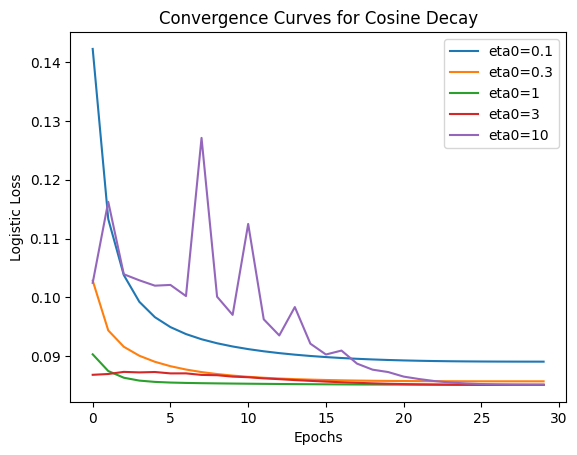

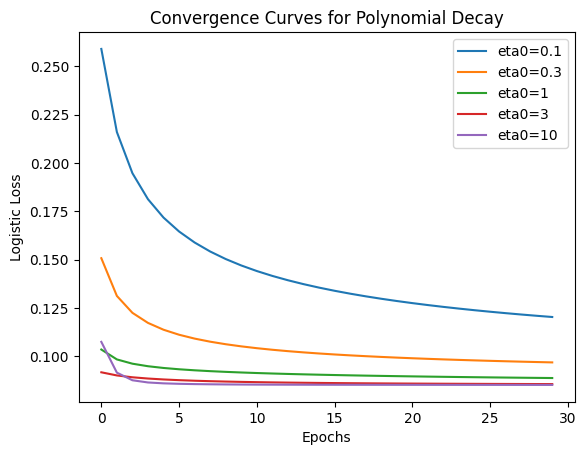

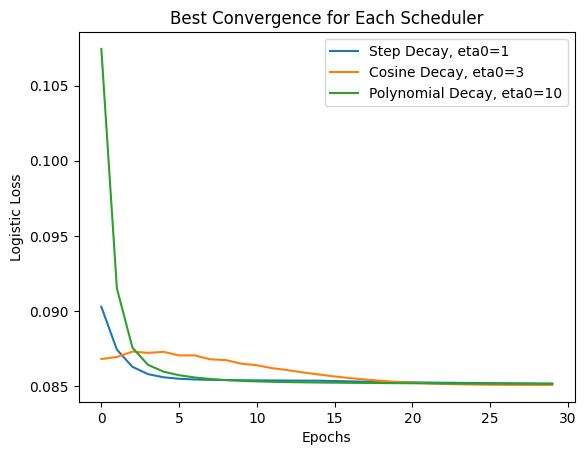

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_svmlight_file


# Load and preprocess load_breast_cancer  dataset
# from sklearn.datasets import load_breast_cancer
# data = load_breast_cancer()
# X, y = data.data, data.target
# y = np.where(y == 0, -1, 1)  # Convert labels to {-1, 1}
# X = StandardScaler().fit_transform(X)  # Standardize features
# train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

X, y = load_svmlight_file("breast-cancer_scale")
y = np.where(y == 2, -1, y)
y = np.where(y == 4, 1, y)
X = StandardScaler().fit_transform(X.toarray())  # Standardize features
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.001, random_state=41)

# Logistic regression objective function
def logistic_loss(w, X, y):
    return np.mean(np.log(1 + np.exp(-y * np.dot(X, w))))

# SGD with different learning rate schedulers
def sgd(X, y, epochs, batch_size, lr_scheduler, eta0, **kwargs):
    n, d = X.shape
    w = np.zeros(d)  # Initialize weights
    losses = []
    set_lr = []
    
    t = 0 # iteration count
    for epoch in range(epochs):
        for i in range(0, n, batch_size):
            Xi = X[i:i + batch_size]
            yi = y[i:i + batch_size]
            grad = -np.dot(yi * np.exp(-yi * np.dot(Xi, w)) / (1 + np.exp(-yi * np.dot(Xi, w))), Xi)
            eta = lr_scheduler(t, eta0, **kwargs)
            set_lr.append(eta)
            w -= eta * grad / batch_size
            t = t + 1
        losses.append(logistic_loss(w, X, y))
    
    return set_lr, losses

# Hyperparameters
num_of_epochs = 30
batch_size = 16
initial_lrs = [0.1, 0.3, 1, 3, 10]     # Initial learning rate (can be tuned)
eta_min = 0.001  # Minimum learning rate
iterations_per_epoch = np.ceil(len(train_X) / batch_size)
t0 = 15 * iterations_per_epoch  #t0 is the number of iterations after which the learning rate
alpha = 0.5      # Decay exponent
gamma = 0.1
T = num_of_epochs * iterations_per_epoch #total number of iterations
print("num_of_epochs=",num_of_epochs, "batch_size=",batch_size, "eta_min=",eta_min, "iterations_per_epoch=",iterations_per_epoch, "t0=",t0, "alpha=",alpha, "gamma=",gamma, "T=",T)

# Step decay scheduler
def step_decay(t, eta0, gamma=0.1, t0=t0):
    if(t<= 0):
        return eta0
    return eta0 * (gamma ** (t // t0))
    
# Cosine decay scheduler
def cosine_decay(t, eta0, eta_min=0.001, T=T):
    if(t<= 0):
        return eta0
    return eta_min + 0.5 * (eta0 - eta_min) * (1 + np.cos(t * np.pi / T))

# Polynomial decay scheduler
def polynomial_decay(t, eta0, alpha=0.5):
    if(t<= 0):
        return eta0
    return eta0 / (t ** alpha)



# Running SGD for different schedulers
schedulers = {'Step Decay': step_decay, 'Cosine Decay': cosine_decay, 'Polynomial Decay': polynomial_decay}
results = {}
results_lrs = {}

for name, scheduler in schedulers.items():
    for eta0 in initial_lrs:
        set_lr_result, losses = sgd(train_X, train_y, num_of_epochs, batch_size, scheduler, eta0)
        results[(name, eta0)] = losses
        results_lrs[(name, eta0)] = set_lr_result

# Plot Learning Rate Curves for each scheduler
for name, scheduler in schedulers.items():
    plt.figure()
    for eta0 in initial_lrs:
        plt.plot(results_lrs[(name, eta0)], label=f'eta0={eta0}')
        #print(name, eta0, results_lrs[(name, eta0)])
    plt.title(f'Learning Rate Curves for {name}')
    plt.xlabel('Interations')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.show()

# Plot convergence curves for each scheduler and learning rate
for name, scheduler in schedulers.items():
    plt.figure()
    for eta0 in initial_lrs:
        plt.plot(results[(name, eta0)], label=f'eta0={eta0}')
        #print(name, eta0, results[(name, eta0)][-1])
    plt.title(f'Convergence Curves for {name}')
    plt.xlabel('Epochs')
    plt.ylabel('Logistic Loss')
    plt.legend()
    plt.show()


# Compare the best convergence curves for each scheduler
plt.figure()
for idx, name in enumerate(schedulers.keys()):
    best_eta0 = min(initial_lrs, key=lambda lr: results[(name, lr)][-1])
    plt.plot(results[(name, best_eta0)], label=f'{name}, eta0={best_eta0}')
plt.title('Best Convergence for Each Scheduler')
plt.xlabel('Epochs')
plt.ylabel('Logistic Loss')
plt.legend()
plt.show()

